In [1]:
from pyspark.sql import SparkSession

# Core Libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
%matplotlib inline

# Set color palette for Seaborn
colors = ["#26536f", "#3b96b7", "#749ca8", "#b6a98d", "#c78a4d", "#854927"]
sns.set_palette(colors)

# Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, auc
)

In [2]:
# Create a Spark session
spark = SparkSession.builder.appName("Ecommerce_Analysis").getOrCreate()

In [3]:
# Load the dataset (Replace 'dataset.csv' with the actual file path)
df = spark.read.csv("Ecommerce.csv", header=True, inferSchema=True)

In [4]:
# Display schema to check data types
df.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: string (nullable = true)
 |-- order_approved_at: string (nullable = true)
 |-- order_delivered_carrier_date: string (nullable = true)
 |-- order_delivered_customer_date: string (nullable = true)
 |-- order_estimated_delivery_date: string (nullable = true)
 |-- order_item_id: double (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- freight_value: string (nullable = true)
 |-- payment_sequential: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- payment_installments: string (nullable = true)
 |-- payment_value: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- review_score: string (nullable = true)
 |-- review_comment_title: string (nullable 

In [5]:
df.count()

123553

In [6]:
# Show first few records
df.show()

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+-------------+--------------------+--------------------+-------------------+------+-------------+------------------+------------+--------------------+-------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+--------------------+------------------------+--------------------+--------------+----------------------+--------------------+------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|order_item_id|          product_id|

# Handling Missing Values

In [7]:
from pyspark.sql.functions import col, sum

# Count missing/null values in each column
missing_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts.show()

+--------+-----------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+-------------+----------+---------+-------------------+-----+-------------+------------------+------------+--------------------+-------------+---------+------------+--------------------+----------------------+--------------------+-----------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+------------------+------------------------+-------------+--------------+----------------------+-----------+------------+
|order_id|customer_id|order_status|order_purchase_timestamp|order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|order_item_id|product_id|seller_id|shipping_limit_date|price|freight_value|payment_sequential|payment_type|payment_installments|paym

### Step 1: Drop Columns with Excessive Missing Values
If certain columns have a very high percentage of missing values (e.g., review_comment_title, review_comment_message), it's better to drop them.

In [8]:
df = df.drop("review_comment_title", "review_comment_message", "product_name_lenght", "product_description_lenght","product_photos_qty", "product_weight_g","product_height_cm", "product_width_cm","product_length_cm", "customer_unique_id", "customer_zip_code_prefix", "seller_zip_code_prefix")

### Step 2: Fill Missing Values for Important Columns

In [9]:
from pyspark.sql.functions import mean

num_cols = ["price", "freight_value"]

for col_name in num_cols:
    mean_value = df.select(mean(col(col_name))).collect()[0][0]
    df = df.fillna({col_name: mean_value})

In [10]:
cat_cols = ["product_category_name", "customer_city", "customer_state", "seller_city", "seller_state"]

for col_name in cat_cols:
    df = df.fillna({col_name: "Unknown"})

In [11]:
from pyspark.sql.functions import to_date, lit

date_cols = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date",
             "order_delivered_customer_date", "order_estimated_delivery_date",
             "shipping_limit_date", "review_creation_date", "review_answer_timestamp"]

for col_name in date_cols:
    df = df.fillna({col_name: "1970-01-01"})
    df = df.withColumn(col_name, to_date(col(col_name)))

In [12]:
df = df.dropna(subset=["order_delivered_customer_date", "review_score", "order_item_id","review_creation_date","review_answer_timestamp","order_purchase_timestamp"])

In [13]:
missing_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts.show()

+--------+-----------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+-------------+----------+---------+-------------------+-----+-------------+------------------+------------+--------------------+-------------+---------+------------+--------------------+-----------------------+---------------------+-------------+--------------+-----------+------------+
|order_id|customer_id|order_status|order_purchase_timestamp|order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|order_item_id|product_id|seller_id|shipping_limit_date|price|freight_value|payment_sequential|payment_type|payment_installments|payment_value|review_id|review_score|review_creation_date|review_answer_timestamp|product_category_name|customer_city|customer_state|seller_city|seller_state|
+--------+-----------+------------+------------------------+-----------------+--------------

In [14]:
df.count()

117249

In [15]:
df = df.toPandas()

In [16]:
# Ensure timestamps are in datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

# Create useful features from order_purchase_timestamp
df['day_of_week_int'] = df['order_purchase_timestamp'].dt.weekday + 1  # Day of week as integer (1 = Monday, etc.)
df['hour'] = df['order_purchase_timestamp'].dt.hour                    # Hour of day
df['month'] = df['order_purchase_timestamp'].dt.month                  # Month as integer
df['year'] = df['order_purchase_timestamp'].dt.year                    # Year as integer
df['date'] = df['order_purchase_timestamp'].dt.to_period('M')          # Monthly period for time series analysis

# Calculate delivery time in days
df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

In [17]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [18]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_city,customer_state,seller_city,seller_state,day_of_week_int,hour,month,year,date,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,sao paulo,SP,maua,SP,1,0,10,2017,2017-10,8
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,sao paulo,SP,maua,SP,1,0,10,2017,2017-10,8
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,sao paulo,SP,maua,SP,1,0,10,2017,2017-10,8
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,...,barreiras,BA,belo horizonte,SP,2,0,7,2018,2018-07,14
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,...,vianopolis,GO,guariba,SP,3,0,8,2018,2018-08,9


# EDA

### Monthly Sales Trend (Line Plot)

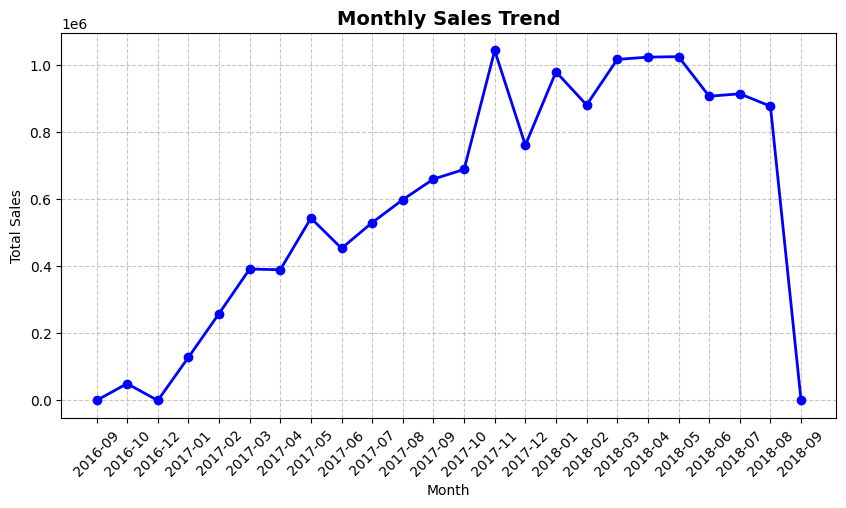

In [19]:
# Aggregate monthly sales
monthly_sales = df.groupby(df['order_purchase_timestamp'].dt.to_period('M'))['price'].sum()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales.index.astype(str), monthly_sales, marker='o', linestyle='-', color='b', linewidth=2)

# Labels and formatting
plt.title('Monthly Sales Trend', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Total Sales by Product Category (Bar Plot)

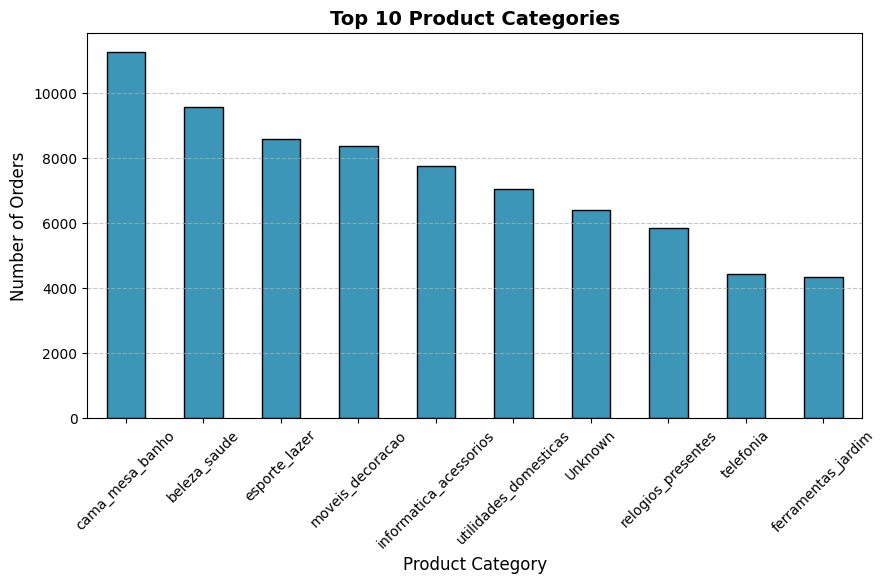

In [20]:
# Plot top 10 product categories
df['product_category_name'].value_counts().head(10).plot(
    kind='bar', figsize=(10, 5), color=colors[1], edgecolor='black'
)

# Add titles and labels
plt.title('Top 10 Product Categories', fontsize=14, fontweight='bold')
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)

# Customize ticks and gridlines
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Proportion of Total Sales by Payment Type (Pie Chart)

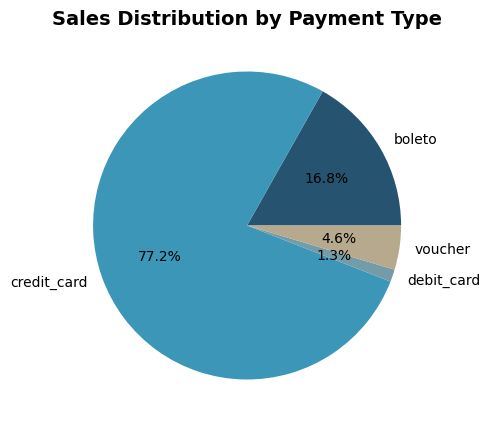

In [21]:
# Plot sales distribution by payment type
df.groupby('payment_type')['price'].sum().plot(
    kind='pie', autopct='%1.1f%%', colors=colors, figsize=(5,5), ylabel='')

# Add title
plt.title('Sales Distribution by Payment Type', fontsize=14, fontweight='bold')

plt.show()

### Distribution of Review Scores (Histogram)

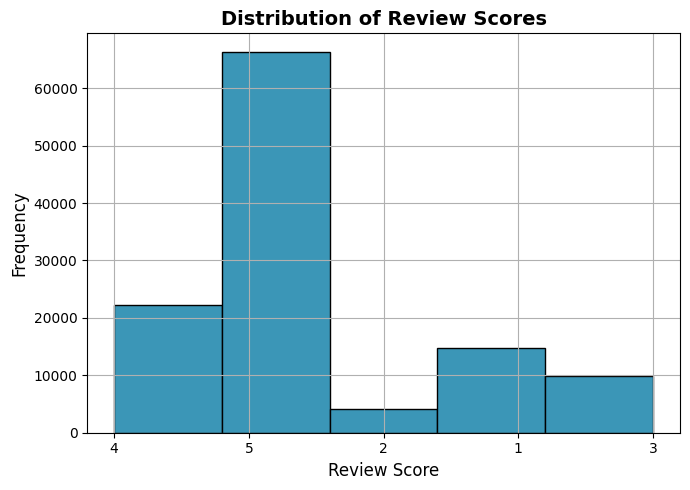

In [22]:
# Plot distribution of review scores
df['review_score'].hist(bins=5, color=colors[1], edgecolor='black', figsize=(7, 5), grid=True)

# Add title and labels
plt.title('Distribution of Review Scores', fontsize=14, fontweight='bold')
plt.xlabel('Review Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()


### Correlation Heatmap

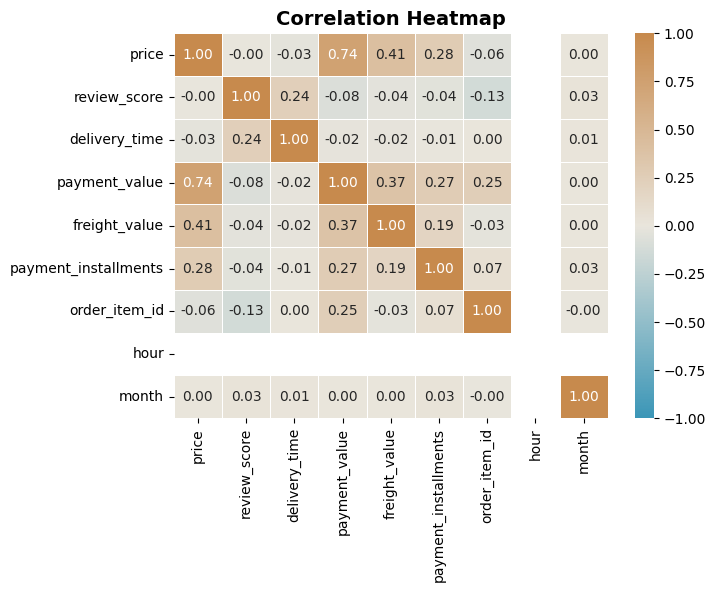

In [23]:
# Select relevant features and compute correlation matrix
correlation = df[['price', 'review_score', 'delivery_time',
                  'payment_value', 'freight_value', 'payment_installments',
                  'order_item_id', 'hour', 'month']].corr()

# Define custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ['#3B96B7', '#E9E5DC', '#C78A4D'])

# Plot heatmap
plt.figure(figsize=(7,5))
sns.heatmap(correlation, annot=True, cmap=custom_cmap, vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)

plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.show()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117249 entries, 0 to 117248
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117249 non-null  object        
 1   customer_id                    117249 non-null  object        
 2   order_status                   117249 non-null  object        
 3   order_purchase_timestamp       117249 non-null  datetime64[ns]
 4   order_approved_at              117249 non-null  object        
 5   order_delivered_carrier_date   117249 non-null  object        
 6   order_delivered_customer_date  117249 non-null  datetime64[ns]
 7   order_estimated_delivery_date  117249 non-null  object        
 8   order_item_id                  117249 non-null  float64       
 9   product_id                     117249 non-null  object        
 10  seller_id                      117249 non-null  object        
 11  

In [25]:
df.shape

(117249, 33)

# FEATURE ENGINEERING

In [26]:
df_sentiment = df.copy()
df_recommendation = df[['customer_id', 'product_id', 'review_score', 'product_category_name', 'price', 'freight_value']].copy()

In [27]:
df_sentiment.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_city,customer_state,seller_city,seller_state,day_of_week_int,hour,month,year,date,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,sao paulo,SP,maua,SP,1,0,10,2017,2017-10,8
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,sao paulo,SP,maua,SP,1,0,10,2017,2017-10,8
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,sao paulo,SP,maua,SP,1,0,10,2017,2017-10,8
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,...,barreiras,BA,belo horizonte,SP,2,0,7,2018,2018-07,14
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,...,vianopolis,GO,guariba,SP,3,0,8,2018,2018-08,9


In [28]:
df_recommendation.head()

,customer_id,product_id,review_score,product_category_name,price,freight_value
0,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,4,utilidades_domesticas,29.99,8.72
1,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,4,utilidades_domesticas,29.99,8.72
2,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,4,utilidades_domesticas,29.99,8.72
3,b0830fb4747a6c6d20dea0b8c802d7ef,595fac2a385ac33a80bd5114aec74eb8,4,perfumaria,118.70,22.76
4,41ce2a54c0b03bf3443c3d931a367089,aa4383b373c6aca5d8797843e5594415,5,automotivo,159.90,19.22


## Feature Engineering for Sentiment Analysis

In [29]:
df1 = df[['order_status', 'payment_type','price', 'freight_value','payment_sequential','payment_installments','payment_value','delivery_time','day_of_week_int','order_delivered_customer_date','order_estimated_delivery_date', 'product_category_name', 'customer_state', 'seller_state','review_score']]

In [30]:
df1.head()

,order_status,payment_type,price,freight_value,payment_sequential,payment_installments,payment_value,delivery_time,day_of_week_int,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,customer_state,seller_state,review_score
0,delivered,credit_card,29.99,8.72,1,1,18.12,8,1,2017-10-10,2017-10-18,utilidades_domesticas,SP,SP,4
1,delivered,voucher,29.99,8.72,3,1,2.0,8,1,2017-10-10,2017-10-18,utilidades_domesticas,SP,SP,4
2,delivered,voucher,29.99,8.72,2,1,18.59,8,1,2017-10-10,2017-10-18,utilidades_domesticas,SP,SP,4
3,delivered,boleto,118.70,22.76,1,1,141.46,14,2,2018-08-07,2018-08-13,perfumaria,BA,SP,4
4,delivered,credit_card,159.90,19.22,1,3,179.12,9,3,2018-08-17,2018-09-04,automotivo,GO,SP,5


In [31]:
# Convert both columns to pandas Timestamps
df1['order_delivered_customer_date'] = pd.to_datetime(df1['order_delivered_customer_date'])
df1['order_estimated_delivery_date'] = pd.to_datetime(df1['order_estimated_delivery_date'])

# Now subtract the two columns
df1['delivery_delay'] = df1['order_delivered_customer_date'] - df1['order_estimated_delivery_date']

# Create the 'on_time_delivery' column
df1['on_time_delivery'] = df1['delivery_delay'].apply(lambda x: 1 if x <= pd.Timedelta(0) else 0)

C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_24384\1691073800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['order_delivered_customer_date'] = pd.to_datetime(df1['order_delivered_customer_date'])
C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_24384\1691073800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['order_estimated_delivery_date'] = pd.to_datetime(df1['order_estimated_delivery_date'])
C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_24384\1691073800.py:6: SettingWithCopyWarning: 
A

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df1[['price', 'freight_value', 'payment_value']] = scaler.fit_transform(
    df1[['price', 'freight_value', 'payment_value']]
)

C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_24384\845053363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[['price', 'freight_value', 'payment_value']] = scaler.fit_transform(


In [33]:
df1 = pd.get_dummies(df1, columns=['product_category_name'], drop_first=True)
df1 = pd.get_dummies(df1, columns=['payment_type'], drop_first=True)
df1 = pd.get_dummies(df1, columns=['order_status'], drop_first=True)

In [34]:
df1['is_weekend_purchase'] = df1['day_of_week_int'].apply(lambda x: 1 if x in [5, 6] else 0)

In [35]:
columns_to_drop = [
    "order_delivered_customer_date", "order_estimated_delivery_date",
    "customer_state", "seller_state",
    "payment_sequential", "payment_installments", "delivery_delay"
]

df1 = df1.drop(columns=columns_to_drop)

In [36]:
df1.columns

Index(['price', 'freight_value', 'payment_value', 'delivery_time',
       'day_of_week_int', 'review_score', 'on_time_delivery',
       'product_category_name_agro_industria_e_comercio',
       'product_category_name_alimentos',
       'product_category_name_alimentos_bebidas',
       'product_category_name_artes',
       'product_category_name_artes_e_artesanato',
       'product_category_name_artigos_de_festas',
       'product_category_name_artigos_de_natal', 'product_category_name_audio',
       'product_category_name_automotivo', 'product_category_name_bebes',
       'product_category_name_bebidas', 'product_category_name_beleza_saude',
       'product_category_name_brinquedos',
       'product_category_name_cama_mesa_banho',
       'product_category_name_casa_conforto',
       'product_category_name_casa_conforto_2',
       'product_category_name_casa_construcao',
       'product_category_name_cds_dvds_musicais',
       'product_category_name_cine_foto', 'product_category_name_cl

In [37]:
from sklearn.model_selection import train_test_split

# Define target variable
X = df1.drop(['review_score'], axis=1)
y = df1['review_score']

# Split into Train & Test Sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [38]:
# Identify timedelta columns
timedelta_cols = X_train.select_dtypes(include=['timedelta64']).columns

# Convert to numeric (e.g., seconds)
for col in timedelta_cols:
    X_train[col] = X_train[col].dt.total_seconds()
    X_test[col] = X_test[col].dt.total_seconds()

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred_logreg = log_reg.predict(X_test)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

C:\Users\ASUS ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression Accuracy: 0.5905330490405117
              precision    recall  f1-score   support

           1       0.62      0.26      0.37      2961
           2       0.00      0.00      0.00       816
           3       0.00      0.00      0.00      1967
           4       0.00      0.00      0.00      4455
           5       0.59      0.99      0.74     13251

    accuracy                           0.59     23450
   macro avg       0.24      0.25      0.22     23450
weighted avg       0.41      0.59      0.46     23450



C:\Users\ASUS ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train model
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluation
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.6063965884861408
              precision    recall  f1-score   support

           1       0.62      0.39      0.48      2961
           2       0.52      0.02      0.04       816
           3       0.27      0.01      0.03      1967
           4       0.44      0.02      0.03      4455
           5       0.61      0.98      0.75     13251

    accuracy                           0.61     23450
   macro avg       0.49      0.28      0.26     23450
weighted avg       0.55      0.61      0.49     23450



In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.6019189765458423


C:\Users\ASUS ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.64      0.35      0.45      2961
           2       1.00      0.00      0.01       816
           3       1.00      0.00      0.00      1967
           4       0.00      0.00      0.00      4455
           5       0.60      0.99      0.75     13251

    accuracy                           0.60     23450
   macro avg       0.65      0.27      0.24     23450
weighted avg       0.54      0.60      0.48     23450



C:\Users\ASUS ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Encode labels to numeric format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train_encoded)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Convert predictions back to original labels
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb)

# Evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.6077185501066098
              precision    recall  f1-score   support

           1       0.62      0.40      0.49      2961
           2       1.00      0.01      0.03       816
           3       0.68      0.01      0.01      1967
           4       0.79      0.00      0.01      4455
           5       0.61      0.98      0.75     13251

    accuracy                           0.61     23450
   macro avg       0.74      0.28      0.26     23450
weighted avg       0.66      0.61      0.49     23450



In [43]:
# from sklearn.svm import SVC

# # Ensure y_train and y_test are in their original format (not encoded)
# y_train_original = label_encoder.inverse_transform(y_train_encoded)
# y_test_original = label_encoder.inverse_transform(y_test_encoded)

# ### **SVC Model**
# svc_model = SVC(kernel='rbf', C=1.0, random_state=42)
# svc_model.fit(X_train, y_train_original)

# y_pred_svc = svc_model.predict(X_test)

# print("SVC Accuracy:", accuracy_score(y_test_original, y_pred_svc))
# print(classification_report(y_test_original, y_pred_svc))

In [44]:
# from sklearn.neural_network import MLPClassifier

# ### **MLPClassifier Model**
# mlp_model = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=500, random_state=42)
# mlp_model.fit(X_train, y_train_original)

# y_pred_mlp = mlp_model.predict(X_test)

# print("MLP Accuracy:", accuracy_score(y_test_original, y_pred_mlp))
# print(classification_report(y_test_original, y_pred_mlp))

Final Features for df_sentiment

* Numerical:` price`,` freight_value`, `payment_value`, `delivery_delay`, `on_time_delivery`,` is_weekend_purchase`
* Categorical (Encoded): `payment_type_encoded`, `order_status_encoded`, `product_category_name_encoded`

## Feature Engineering for Recommendation System

#### Step 1: Drop Missing Reviews

In [45]:
df_recommendation = df_recommendation.dropna(subset=['review_score'])

#### Step 2: Encode Categorical Variables

In [46]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_recommendation['product_category_encoded'] = le.fit_transform(df_recommendation['product_category_name'])
df_recommendation = df_recommendation.drop(['product_category_name'], axis=1)

#### Step 3: Normalize Price

In [47]:
df_recommendation['normalized_price'] = (df_recommendation['price'] - df_recommendation['price'].mean()) / df_recommendation['price'].std()

#### Step 4: Convert Ratings into Implicit Feedback

In [48]:
df_recommendation['review_score'] = pd.to_numeric(df_recommendation['review_score'], errors='coerce')
df_recommendation['positive_review'] = df_recommendation['review_score'].apply(lambda x: 1 if x >= 4 else 0)

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_recommendation[['normalized_price', 'freight_value']] = scaler.fit_transform(df_recommendation[['price', 'freight_value']])

Final Features for df_recommendation

* Collaborative Filtering: `customer_id`, `product_id`, `review_score`
* Content-Based Filtering: `product_category_encoded`, `normalized_price`, `freight_value`

In [50]:
df_recommendation.head()

,customer_id,product_id,review_score,price,freight_value,product_category_encoded,normalized_price,positive_review
0,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,4,29.99,0.021285,73,0.004327,1
1,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,4,29.99,0.021285,73,0.004327,1
2,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,4,29.99,0.021285,73,0.004327,1
3,b0830fb4747a6c6d20dea0b8c802d7ef,595fac2a385ac33a80bd5114aec74eb8,4,118.70,0.055556,63,0.017500,1
4,41ce2a54c0b03bf3443c3d931a367089,aa4383b373c6aca5d8797843e5594415,5,159.90,0.046915,9,0.023618,1


In [51]:
from sklearn.preprocessing import LabelEncoder

customer_encoder = LabelEncoder()
product_encoder = LabelEncoder()

df_recommendation['customer_id_encoded'] = customer_encoder.fit_transform(df['customer_id'])
df_recommendation['product_id_encoded'] = product_encoder.fit_transform(df['product_id'])

In [52]:
df_recommendation.columns

Index(['customer_id', 'product_id', 'review_score', 'price', 'freight_value',
       'product_category_encoded', 'normalized_price', 'positive_review',
       'customer_id_encoded', 'product_id_encoded'],
      dtype='object')

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Load the DataFrame (df_recommendation) into a Pandas DataFrame
# df_recommendation = pd.read_csv("your_data.csv")  # Example

# Step 2: Check for missing values
#df_recommendation.isnull().sum()

# Handle missing values (for example, by filling them with the mean)
# df_recommendation.fillna(df_recommendation.mean(), inplace=True)

# Step 3: Features and Target Variable
X = df_recommendation[['price', 'freight_value', 'product_category_encoded', 'normalized_price', 'positive_review']]
y = df_recommendation['review_score']

# Step 4: Scale the numerical features (price, freight_value, normalized_price)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['price', 'freight_value', 'normalized_price']])

# Add the other features (already encoded) without scaling
X_scaled = np.hstack([X_scaled, X[['product_category_encoded', 'positive_review']].values])

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [54]:
# Step 6: Initialize the KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors (k)

# Step 7: Train the KNN Model
knn.fit(X_train, y_train)

# Step 8: Predict on the test set
y_pred = knn.predict(X_test)

# Step 9: Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.6334539966602637


In [55]:
# Trying different values of k
for k in range(1, 21):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"k = {k}, RMSE = {rmse}")

k = 1, RMSE = 0.7580977202960867
k = 2, RMSE = 0.6762652991226457
k = 3, RMSE = 0.6494872506057069
k = 4, RMSE = 0.6389519503708626
k = 5, RMSE = 0.6334539966602637
k = 6, RMSE = 0.6287973953635743
k = 7, RMSE = 0.6257816138703072
k = 8, RMSE = 0.6239463399854484
k = 9, RMSE = 0.6223216321576633
k = 10, RMSE = 0.6218690446886742
k = 11, RMSE = 0.6222260332000186
k = 12, RMSE = 0.6222363679561024
k = 13, RMSE = 0.6227197335213894
k = 14, RMSE = 0.6230938471050417
k = 15, RMSE = 0.6240177498250026
k = 16, RMSE = 0.6239373962722149
k = 17, RMSE = 0.624738692322056
k = 18, RMSE = 0.6256285370420016
k = 19, RMSE = 0.6263636465374768
k = 20, RMSE = 0.6274832119162024


In [56]:
# Final model with the best k
best_k = 5  # Suppose the best k is found to be 5
final_knn = KNeighborsRegressor(n_neighbors=best_k)
final_knn.fit(X_train, y_train)

# Predict on new data
new_predictions = final_knn.predict(X_test)

In [57]:
new_predictions

array([2. , 1. , 1.8, ..., 5. , 4.8, 4.6])

In [58]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 0.6274832119162024


In [59]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 0.49871215351812365


In [60]:
from sklearn.metrics import r2_score

# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")


R-squared (R²): 0.7958207583594645


In [61]:
from sklearn.metrics import explained_variance_score

# Calculate Explained Variance Score
evs = explained_variance_score(y_test, y_pred)
print(f"Explained Variance Score: {evs}")


Explained Variance Score: 0.7958664836316938


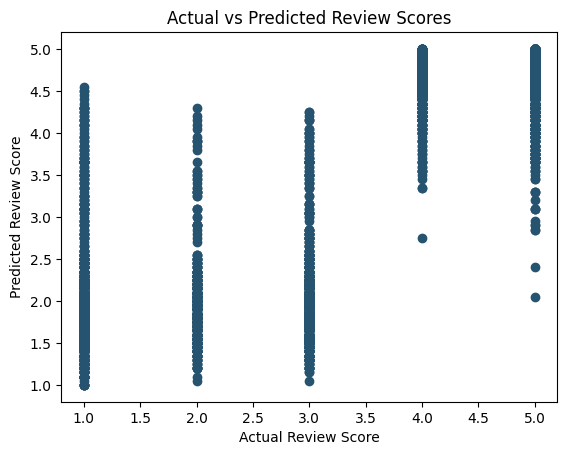

In [62]:
import matplotlib.pyplot as plt

# Plotting the actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Review Score")
plt.ylabel("Predicted Review Score")
plt.title("Actual vs Predicted Review Scores")
plt.show()


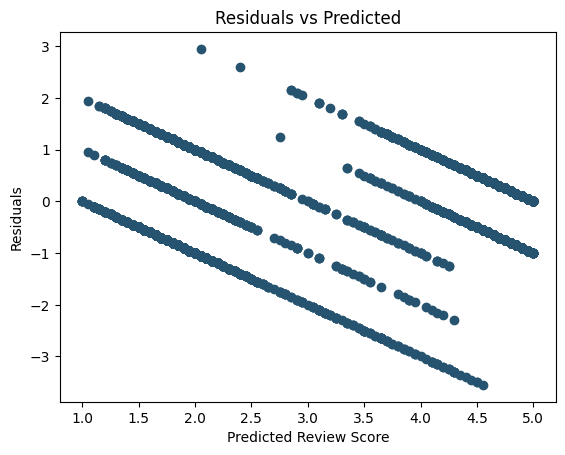

In [63]:
# Plot residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Review Score")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


In [64]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [65]:
# Let's assume df_recommendation is your DataFrame
df_recommendation['customer_id'] = df_recommendation['customer_id'].astype(str)  # Ensure customer_id is a string

# Feature scaling
scaler = StandardScaler()
df_recommendation[['price', 'freight_value', 'normalized_price']] = scaler.fit_transform(df_recommendation[['price', 'freight_value', 'normalized_price']])

# For encoding, we could use one-hot encoding for categorical columns if required.
df_recommendation = pd.get_dummies(df_recommendation, columns=['product_category_encoded'], drop_first=True)

In [66]:
# Filter top 1000 most frequently purchased products
top_products = df_recommendation['product_id'].value_counts().index[:1000]
df_filtered = df_recommendation[df_recommendation['product_id'].isin(top_products)]

In [67]:
df_recommendation['price'] = df_recommendation['price'].astype('float32')
df_recommendation['freight_value'] = df_recommendation['freight_value'].astype('float32')
df_recommendation['normalized_price'] = df_recommendation['normalized_price'].astype('float32')

In [68]:
df_grouped = df_recommendation.groupby(['customer_id', 'product_id'])[['price', 'freight_value', 'normalized_price']].mean().reset_index()

In [69]:
from scipy.sparse import csr_matrix

pivot_table = df_filtered.pivot_table(index='customer_id', columns='product_id', values=['price', 'freight_value', 'normalized_price'], aggfunc='mean')

# Convert to a sparse matrix
pivot_table_sparse = csr_matrix(pivot_table.fillna(0).values)


In [70]:
pivot_table = pivot_table.fillna(0)

In [71]:
# Initialize the KNN model with the number of neighbors
knn = NearestNeighbors(n_neighbors=5, metric='cosine')

# Fit the model on the customer-product feature matrix
knn.fit(pivot_table)

NearestNeighbors(metric='cosine')

In [72]:
# Let's say you want to recommend products for a specific customer
customer_id = '00012a2ce6f8dcda20d059ce98491703'  # Example customer ID

# Find the nearest neighbors (products) for the customer
distances, indices = knn.kneighbors(pivot_table.loc[customer_id].values.reshape(1, -1))

# Get the recommended product IDs
# recommended_product_ids = pivot_table.columns[indices.flatten()]
recommended_product_ids = [pivot_table.columns[i] for i in indices.flatten() if i < len(pivot_table.columns)]
print(recommended_product_ids)

[('freight_value', '008cff0e5792219fae03e570f980b330')]


In [92]:
pivot_table

freight_value  \
product_id                       008cff0e5792219fae03e570f980b330   
customer_id                                                         
00012a2ce6f8dcda20d059ce98491703                              0.0   
0004164d20a9e969af783496f3408652                              0.0   
00066ccbe787a588c52bd5ff404590e3                              0.0   
000e943451fc2788ca6ac98a682f2f49                              0.0   
000fd45d6fedae68fc6676036610f879                              0.0   
...                                                           ...   
fff5dd22d522cf28a902185817642a2e                              0.0   
fff906ecb75de5809be384e0f8d65e45                              0.0   
fffb97495f78be80e2759335275df2aa                              0.0   
ffff42319e9b2d713724ae527742af25                              0.0   
ffffa3172527f765de70084a7e53aae8                              0.0   

                                                                   \
product_id                       00de7f393d962717eeeb2d7131a40dba   
customer_id                                                         
00012a2ce6f8dcda20d059ce98491703                              0.0   
0004164d20a9e969af783496f3408652                              0.0   
00066ccbe787a588c52bd5ff404590e3                              0.0   
000e943451fc2788ca6ac98a682f2f49                              0.0   
000fd45d6fedae68fc6676036610f879                              0.0   
...                                                           ...   
fff5dd22d522cf28a902185817642a2e                              0.0   
fff906ecb75de5809be384e0f8d65e45                              0.0   
fffb97495f78be80e2759335275df2aa                              0.0   
ffff42319e9b2d713724ae527742af25                              0.0   
ffffa3172527f765de70084a7e53aae8                              0.0   

                                                                   \
product_id                       014a8a503291921f7b004a5215bb3c36   
customer_id                                                         
00012a2ce6f8dcda20d059ce98491703                              0.0   
0004164d20a9e969af783496f3408652                              0.0   
00066ccbe787a588c52bd5ff404590e3                              0.0   
000e943451fc2788ca6ac98a682f2f49                              0.0   
000fd45d6fedae68fc6676036610f879                              0.0   
...                                                           ...   
fff5dd22d522cf28a902185817642a2e                              0.0   
fff906ecb75de5809be384e0f8d65e45                              0.0   
fffb97495f78be80e2759335275df2aa                              0.0   
ffff42319e9b2d713724ae527742af25                              0.0   
ffffa3172527f765de70084a7e53aae8                              0.0   

                                                                   \
product_id                       0152f69b6cf919bcdaf117aa8c43e5a2   
customer_id                                                         
00012a2ce6f8dcda20d059ce98491703                              0.0   
0004164d20a9e969af783496f3408652                              0.0   
00066ccbe787a588c52bd5ff404590e3                              0.0   
000e943451fc2788ca6ac98a682f2f49                              0.0   
000fd45d6fedae68fc6676036610f879                              0.0   
...                                                           ...   
fff5dd22d522cf28a902185817642a2e                              0.0   
fff906ecb75de5809be384e0f8d65e45                              0.0   
fffb97495f78be80e2759335275df2aa                              0.0   
ffff42319e9b2d713724ae527742af25                              0.0   
ffffa3172527f765de70084a7e53aae8                              0.0   

                                                                   \
product_id                       016711f78a6a87696645db0a6a834826   
customer_id                                   

In [91]:
# Get the index of the customer_id in your pivot_table
customer_index = pivot_table.index.get_loc('00012a2ce6f8dcda20d059ce98491703')

# Get the customer feature vector
customer_vector = pivot_table.iloc[customer_index].values.reshape(1, -1)

# Find the 5 nearest neighbors
distances, indices = knn.kneighbors(customer_vector)

# Retrieve the customer IDs of the nearest neighbors
nearest_customers = pivot_table.index[indices.flatten()]

# Print the customer IDs of the nearest neighbors
print("Nearest customers to '00012a2ce6f8dcda20d059ce98491703':")
for customer in nearest_customers:
    print(f"Product ID: {customer}")



Nearest customers to '00012a2ce6f8dcda20d059ce98491703':
Product ID: 00012a2ce6f8dcda20d059ce98491703
Product ID: 5b1ec7f80273a8f34661d005f2f00071
Product ID: 95c149336929694fcd5da2490558f63d
Product ID: bb66f809e5e058fd11be098c90932c7b
Product ID: 5447af43cbd7d4c3a958bbdd1327b6e3


In [ ]:
import 

In [73]:
'''def recommend_products_for_all_customers(pivot_table, knn, n_neighbors=5):
    recommendations = {}
    for customer_id in pivot_table.index:
        distances, indices = knn.kneighbors(pivot_table.loc[customer_id].values.reshape(1, -1), n_neighbors=n_neighbors)
        # recommended_product_ids = pivot_table.columns[indices.flatten()]
        recommended_product_ids = [pivot_table.columns[i] for i in indices.flatten() if i < len(pivot_table.columns)]
        recommendations[customer_id] = recommended_product_ids
    return recommendations

# Get recommendations for all customers
recommendations = recommend_products_for_all_customers(pivot_table, knn)

SyntaxError: incomplete input (4065652752.py, line 1)

In [ ]:
'''from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Initialize Spark session
spark = SparkSession.builder.appName("Ecommerce_Analysis_Optimized").getOrCreate()

# Load dataset
df = spark.read.csv("Ecommerce.csv", header=True, inferSchema=True).toPandas()

# Feature selection & preprocessing
columns_to_drop = ['order_id', 'customer_id', 'review_id', 'seller_id', 'customer_unique_id']
df.drop(columns=columns_to_drop, inplace=True)

df.fillna(df.median(numeric_only=True), inplace=True)
le = LabelEncoder()
df['product_id'] = le.fit_transform(df['product_id'])
for col in df.select_dtypes(include=['object']).columns:
    if col != 'product_id':
        df[col] = le.fit_transform(df[col])

# Train-test split
X = df.drop('product_id', axis=1)
y = df['product_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training & Evaluation
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

# Display results
print("Model Accuracy Scores:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")


In [82]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from xgboost.spark import SparkXGBClassifier
#from synapse.ml.lightgbm import LightGBMClassifier

# Initialize Spark session
spark = SparkSession.builder.appName("Ecommerce_Analysis_Optimized").getOrCreate()

# Load dataset
df = spark.read.csv("Ecommerce.csv", header=True, inferSchema=True)

# Drop irrelevant columns with high cardinality
columns_to_drop = [
    'order_id', 'customer_id', 'review_id', 'seller_id', 'customer_unique_id',
    'review_comment_title', 'review_comment_message', 'customer_city', 'seller_city'
]
df = df.drop(*columns_to_drop)

# Convert date/time columns to Unix timestamps
date_columns = [
    'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
    'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date',
    'review_creation_date', 'review_answer_timestamp'
]
for col_name in date_columns:
    df = df.withColumn(col_name, unix_timestamp(col(col_name)))

# Convert numerical columns stored as strings to appropriate types
df = df.withColumn("price", col("price").cast("float"))
df = df.withColumn("freight_value", col("freight_value").cast("float"))
df = df.withColumn("payment_sequential", col("payment_sequential").cast("int"))
df = df.withColumn("payment_installments", col("payment_installments").cast("int"))
df = df.withColumn("payment_value", col("payment_value").cast("float"))
df = df.withColumn("review_score", col("review_score").cast("int"))
df = df.withColumn("product_name_lenght", col("product_name_lenght").cast("int"))
df = df.withColumn("product_description_lenght", col("product_description_lenght").cast("int"))
df = df.withColumn("product_photos_qty", col("product_photos_qty").cast("int"))
df = df.withColumn("customer_zip_code_prefix", col("customer_zip_code_prefix").cast("int"))
df = df.withColumn("seller_zip_code_prefix", col("seller_zip_code_prefix").cast("int"))

# Handle missing values
df = df.na.fill(0)

# Fill missing categorical values with a placeholder
df = df.fillna("unknown", subset=['product_id', 'order_status', 'payment_type', 'customer_state', 'product_category_name', 'seller_state'])

# Encode categorical features
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep").fit(df) for col in ['product_id', 'order_status', 'payment_type', 'customer_state', 'product_category_name', 'seller_state']]
for indexer in indexers:
    df = indexer.transform(df)

df = df.drop('order_status', 'payment_type', 'customer_state', 'product_id', 'product_category_name', 'seller_state')

# Assemble features
feature_columns = [col for col in df.columns if col not in ['product_id_index']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
df = scaler.fit(df).transform(df)

# Train-test split (subsample for speed)
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# Train models
models = {
    "RandomForest": RandomForestClassifier(labelCol="product_id_index", featuresCol="scaled_features", numTrees=50, maxDepth=10),
    "GradientBoosting": GBTClassifier(labelCol="product_id_index", featuresCol="scaled_features", maxIter=50, maxDepth=5),
    "XGBoost": SparkXGBClassifier(labelCol="product_id_index", featuresCol="scaled_features", numWorkers=4, maxDepth=5, nEstimators=100)
    #"LightGBM": LightGBMClassifier(labelCol="product_id_index", featuresCol="scaled_features", numIterations=100, maxDepth=5)
}

results = {}
evaluator = MulticlassClassificationEvaluator(labelCol="product_id_index", metricName="accuracy")

for name, model in models.items():
    trained_model = model.fit(train_df)
    predictions = trained_model.transform(test_df)
    acc = evaluator.evaluate(predictions)
    results[name] = acc

# Display results
print("Model Accuracy Scores:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")


ValueError: Please use param name label_col instead.

In [83]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from xgboost.spark import SparkXGBClassifier

# Initialize Spark session
spark = SparkSession.builder.appName("Ecommerce_Analysis_Optimized").getOrCreate()

# Load dataset
df = spark.read.csv("Ecommerce.csv", header=True, inferSchema=True)

# Drop irrelevant columns with high cardinality
columns_to_drop = [
    'order_id', 'customer_id', 'review_id', 'seller_id', 'customer_unique_id',
    'review_comment_title', 'review_comment_message', 'customer_city', 'seller_city'
]
df = df.drop(*columns_to_drop)

# Convert date/time columns to Unix timestamps
date_columns = [
    'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
    'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date',
    'review_creation_date', 'review_answer_timestamp'
]
for col_name in date_columns:
    df = df.withColumn(col_name, unix_timestamp(col(col_name)))

# Convert numerical columns stored as strings to appropriate types
df = df.withColumn("price", col("price").cast("float"))
df = df.withColumn("freight_value", col("freight_value").cast("float"))
df = df.withColumn("payment_sequential", col("payment_sequential").cast("int"))
df = df.withColumn("payment_installments", col("payment_installments").cast("int"))
df = df.withColumn("payment_value", col("payment_value").cast("float"))
df = df.withColumn("review_score", col("review_score").cast("int"))
df = df.withColumn("product_name_lenght", col("product_name_lenght").cast("int"))
df = df.withColumn("product_description_lenght", col("product_description_lenght").cast("int"))
df = df.withColumn("product_photos_qty", col("product_photos_qty").cast("int"))
df = df.withColumn("customer_zip_code_prefix", col("customer_zip_code_prefix").cast("int"))
df = df.withColumn("seller_zip_code_prefix", col("seller_zip_code_prefix").cast("int"))


# Handle missing values
df = df.na.fill(0)

# Fill missing categorical values with a placeholder
df = df.fillna("unknown", subset=['product_id', 'order_status', 'payment_type', 'customer_state', 'product_category_name', 'seller_state'])

# Encode categorical features
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep").fit(df) for col in ['product_id', 'order_status', 'payment_type', 'customer_state', 'product_category_name', 'seller_state']]
for indexer in indexers:
    df = indexer.transform(df)

df = df.drop('order_status', 'payment_type', 'customer_state', 'product_id', 'product_category_name', 'seller_state')

# Assemble features
feature_columns = [col for col in df.columns if col not in ['product_id_index']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
df = scaler.fit(df).transform(df)

# Train-test split (subsample for speed)
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# Train models
models = {
    "RandomForest": RandomForestClassifier(labelCol="product_id_index", featuresCol="scaled_features", numTrees=50, maxDepth=10),
    "GradientBoosting": GBTClassifier(labelCol="product_id_index", featuresCol="scaled_features", maxIter=50, maxDepth=5),
    "XGBoost": SparkXGBClassifier(label_col="product_id_index", features_col="scaled_features", num_workers=4, max_depth=5, n_estimators=100)
    #"LightGBM": LightGBMClassifier(labelCol="product_id_index", featuresCol="scaled_features", numIterations=100, maxDepth=5)
}

results = {}
evaluator = MulticlassClassificationEvaluator(labelCol="product_id_index", metricName="accuracy")

for name, model in models.items():
    trained_model = model.fit(train_df)
    predictions = trained_model.transform(test_df)
    acc = evaluator.evaluate(predictions)
    results[name] = acc

# Display results
print("Model Accuracy Scores:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")

spark.stop() # Stop the Spark session

Py4JJavaError: An error occurred while calling o2510.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 148.0 failed 1 times, most recent failure: Lost task 10.0 in stage 148.0 (TID 886) (LAPTOP-F19N5T4N executor driver): java.lang.OutOfMemoryError: Java heap space

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:663)
	at org.apache.spark.ml.tree.impl.RandomForest$.runBagged(RandomForest.scala:208)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:302)
	at org.apache.spark.ml.classification.RandomForestClassifier.$anonfun$train$1(RandomForestClassifier.scala:168)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:139)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:47)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:78)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.lang.OutOfMemoryError: Java heap space


In [ ]:
kn = KNeighborsClassifier.fit(xtrain, ytrain )

In [93]:
import joblib

In [95]:
file = "name.sav"
o = joblib.dump(knn, file)